<a href="https://colab.research.google.com/github/wkabbani/pytorch-playground/blob/main/huggingface-course/Unit02_01.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Fine-Tuning

## Setup

In [ ]:
!pip install -qq diffusers datasets accelerate wandb open-clip-torch

In [ ]:
from huggingface_hub import notebook_login

notebook_login()

Token is valid.
Your token has been saved in your configured git credential helpers (store).
Your token has been saved to /root/.huggingface/token
Login successful


In [ ]:
import numpy as np
import torch
import torchvision
import torch.nn.functional as F
from datasets import load_dataset
from diffusers import DDIMScheduler, DDPMPipeline
import matplotlib.pyplot as plt
from PIL import Image
from torchvision import transforms
from tqdm.auto import tqdm

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## Loading a pre-trained pipeline

In [ ]:
image_pipe = DDPMPipeline.from_pretrained("google/ddpm-celebahq-256")
image_pipe.to(device)

Fetching 4 files:   0%|          | 0/4 [00:00<?, ?it/s]

DDPMPipeline {
  "_class_name": "DDPMPipeline",
  "_diffusers_version": "0.11.1",
  "scheduler": [
    "diffusers",
    "DDPMScheduler"
  ],
  "unet": [
    "diffusers",
    "UNet2DModel"
  ]
}

  0%|          | 0/1000 [00:00<?, ?it/s]

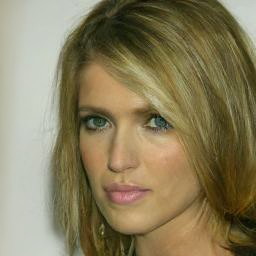

In [ ]:
images = image_pipe().images
images[0]

## Faster Sampling with DDIM

In [ ]:
scheduler = DDIMScheduler.from_pretrained("google/ddpm-celebahq-256")
scheduler.set_timesteps(num_inference_steps=40)

In [ ]:
scheduler.timesteps

tensor([975, 950, 925, 900, 875, 850, 825, 800, 775, 750, 725, 700, 675, 650,
        625, 600, 575, 550, 525, 500, 475, 450, 425, 400, 375, 350, 325, 300,
        275, 250, 225, 200, 175, 150, 125, 100,  75,  50,  25,   0])

0it [00:00, ?it/s]

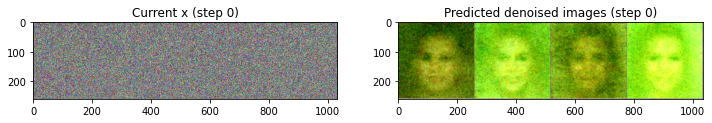

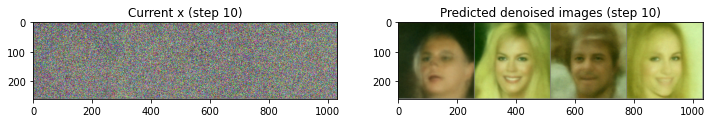

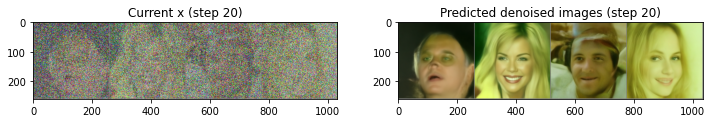

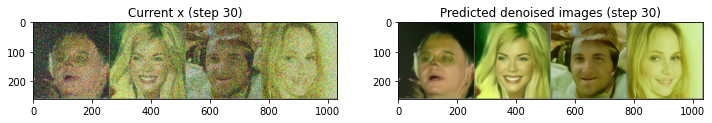

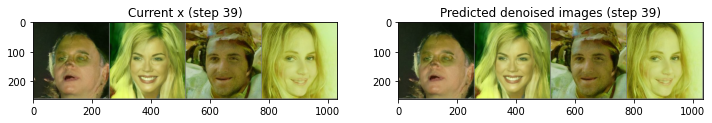

In [ ]:
x = torch.randn(4, 3, 256, 256).to(device)

for i, t in tqdm(enumerate(scheduler.timesteps)):

  model_input = scheduler.scale_model_input(x, t)

  with torch.no_grad():
    noise_pred = image_pipe.unet(model_input, t)['sample']

  scheduler_output = scheduler.step(noise_pred, t, x)

  x = scheduler_output.prev_sample

  if i % 10 == 0 or i == len(scheduler.timesteps) - 1:
    fig, axs = plt.subplots(1, 2, figsize=(12, 5))

    grid = torchvision.utils.make_grid(x, nrow=4).permute(1, 2, 0)
    axs[0].imshow(grid.cpu().clip(-1, 1) * 0.5 + 0.5)
    axs[0].set_title(f"Current x (step {i})")

    pred_x0 = (
        scheduler_output.pred_original_sample
    )  # Not available for all schedulers
    grid = torchvision.utils.make_grid(pred_x0, nrow=4).permute(1, 2, 0)
    axs[1].imshow(grid.cpu().clip(-1, 1) * 0.5 + 0.5)
    axs[1].set_title(f"Predicted denoised images (step {i})")
    plt.show()

  0%|          | 0/40 [00:00<?, ?it/s]

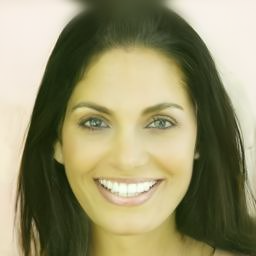

In [ ]:
image_pipe.scheduler = scheduler
images = image_pipe(num_inference_steps=40).images
images[0]

## Fine-Tuning

### Getting a new dataset

In [ ]:
dataset_name = "conorcl/portraits2"
dataset = load_dataset(dataset_name, split="train")
image_size = 256
batch_size = 4

preprocess = transforms.Compose(
    [
        transforms.Resize((image_size, image_size)),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.5], [0.5]),
    ]
)


def transform(examples):
    images = [preprocess(image.convert("RGB")) for image in examples["image"]]
    return {"images": images}


dataset.set_transform(transform)

train_dataloader = torch.utils.data.DataLoader(
    dataset, batch_size=batch_size, shuffle=True
)


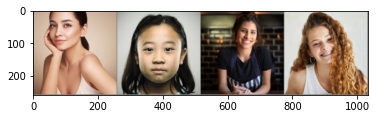

In [ ]:
batch = next(iter(train_dataloader))
grid = torchvision.utils.make_grid(batch["images"], nrow=4)
plt.imshow(grid.permute(1, 2, 0).cpu().clip(-1, 1) * 0.5 + 0.5);

### Training

  0%|          | 0/730 [00:00<?, ?it/s]

Epoch 0 average loss: 0.00908289034940599


  0%|          | 0/730 [00:00<?, ?it/s]

Epoch 1 average loss: 0.008508992661847192


  0%|          | 0/730 [00:00<?, ?it/s]

Epoch 2 average loss: 0.007823901817805377


  0%|          | 0/730 [00:00<?, ?it/s]

Epoch 3 average loss: 0.007649694716672283


  0%|          | 0/730 [00:00<?, ?it/s]

Epoch 4 average loss: 0.008362824924332839


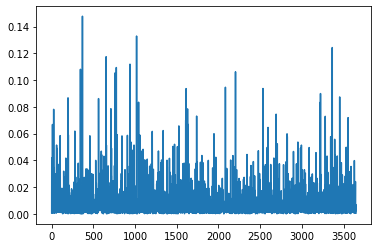

In [ ]:
num_epochs = 5
lr = 1e-5
grad_accumulation_steps = 2

optimizer = torch.optim.AdamW(image_pipe.unet.parameters(), lr=lr)

losses = []

for epoch in range(num_epochs):
    for step, batch in tqdm(enumerate(train_dataloader), total=len(train_dataloader)):
        clean_images = batch["images"].to(device)
        # Sample noise to add to the images
        noise = torch.randn(clean_images.shape).to(clean_images.device)
        bs = clean_images.shape[0]

        # Sample a random timestep for each image
        timesteps = torch.randint(
            0,
            image_pipe.scheduler.num_train_timesteps,
            (bs,),
            device=clean_images.device,
        ).long()

        # Add noise to the clean images according to the noise magnitude at each timestep
        # (this is the forward diffusion process)
        noisy_images = image_pipe.scheduler.add_noise(clean_images, noise, timesteps)

        # Get the model prediction for the noise
        noise_pred = image_pipe.unet(noisy_images, timesteps, return_dict=False)[0]

        # Compare the prediction with the actual noise:
        loss = F.mse_loss(
            noise_pred, noise
        )  # NB - trying to predict noise (eps) not (noisy_ims-clean_ims) or just (clean_ims)

        # Store for later plotting
        losses.append(loss.item())

        # Update the model parameters with the optimizer based on this loss
        loss.backward(loss)

        # Gradient accumulation:
        if (step + 1) % grad_accumulation_steps == 0:
            optimizer.step()
            optimizer.zero_grad()

    print(
        f"Epoch {epoch} average loss: {sum(losses[-len(train_dataloader):])/len(train_dataloader)}"
    )

# Plot the loss curve:
plt.plot(losses)

0it [00:00, ?it/s]

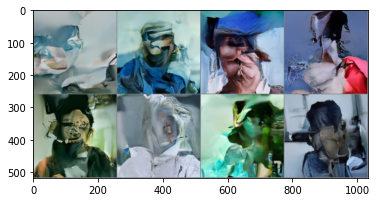

In [ ]:
x = torch.randn(8, 3, 256, 256).to(device)  # Batch of 8
for i, t in tqdm(enumerate(scheduler.timesteps)):
    model_input = scheduler.scale_model_input(x, t)
    with torch.no_grad():
        noise_pred = image_pipe.unet(model_input, t)["sample"]
    x = scheduler.step(noise_pred, t, x).prev_sample
grid = torchvision.utils.make_grid(x, nrow=4)
plt.imshow(grid.permute(1, 2, 0).cpu().clip(-1, 1) * 0.5 + 0.5);